In [287]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [288]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),        
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [289]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x-8*(torch.sin(torch.pi*x/10))**2*torch.exp(-x/15)
    return poten

In [290]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

La=0
Lb =50
L=Lb-La  # domain length
N = 20000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=50
extend_num=0
lr=0.01


In [291]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])
check_en=eigenvalues[:en_num+extend_num]

initial eigenvalues check:
tensor([-5.0022e+01, -1.2810e+01, -7.5801e+00, -7.1249e+00, -6.5373e+00,
        -5.5785e+00, -4.5526e+00, -3.6556e+00, -3.1647e+00, -2.7081e+00,
        -2.6612e+00, -1.8914e+00, -1.7132e+00, -1.4132e+00, -1.3709e+00,
        -1.0903e+00, -1.0757e+00, -7.9964e-01, -7.6744e-01, -6.6943e-01,
        -5.0565e-01, -4.9648e-01, -4.5360e-01, -4.0531e-01, -3.8469e-01,
        -3.5406e-01, -9.3054e-02, -8.6101e-02,  9.8414e-03,  1.2590e-01,
         1.3758e-01,  1.7575e-01,  2.2981e-01,  2.3380e-01,  5.3694e-01,
         6.9163e-01,  7.7848e-01,  8.7657e-01,  9.9557e-01,  1.0175e+00,
         1.3775e+00,  1.4952e+00,  1.6414e+00,  1.7506e+00,  1.9906e+00,
         2.0324e+00,  2.2468e+00,  2.4495e+00,  2.5194e+00,  2.9092e+00],
       device='cuda:1')


In [292]:
a_100_20000 = torch.tensor([-4.9993e+01, -1.2812e+01, -7.6439e+00, -7.1598e+00, -6.5095e+00,
        -5.6153e+00, -4.6651e+00, -3.6987e+00, -3.2770e+00, -2.6482e+00,
        -2.6477e+00, -1.8706e+00, -1.8622e+00, -1.6658e+00, -1.3334e+00,
        -1.2025e+00, -9.7241e-01, -8.6871e-01, -8.5795e-01, -7.9155e-01,
        -5.1720e-01, -5.0087e-01, -4.6173e-01, -4.4192e-01, -2.9187e-01,
        -2.6489e-01, -2.0942e-01, -2.0048e-01, -1.9047e-01, -1.7534e-01,
        -1.3054e-01, -1.2914e-01, -8.4303e-02, -8.3751e-02, -8.2882e-02,
        -6.5835e-02, -4.3924e-02, -2.3980e-02, -1.2305e-02,  1.9596e-02,
         3.3180e-02,  1.1026e-01,  1.4785e-01,  1.5626e-01,  1.8180e-01,
         2.0197e-01,  2.4258e-01,  2.8590e-01,  3.0847e-01,  3.6319e-01],dtype=dtype,device=device)
b_500_20000=torch.tensor([-4.9266e+01, -1.2769e+01, -7.6507e+00, -7.1596e+00, -6.5086e+00,
        -5.6174e+00, -4.6689e+00, -3.6953e+00, -3.2893e+00, -2.7293e+00,
        -2.5762e+00, -1.9258e+00, -1.8134e+00, -1.6713e+00, -1.3562e+00,
        -1.1761e+00, -1.0467e+00, -8.8911e-01, -8.4066e-01, -7.5028e-01,
        -5.5542e-01, -5.1589e-01, -4.9918e-01, -4.0479e-01, -3.0940e-01,
        -3.0296e-01, -2.6865e-01, -2.2188e-01, -2.0477e-01, -1.6500e-01,
        -1.4936e-01, -1.2617e-01, -1.2013e-01, -1.0128e-01, -9.3843e-02,
        -8.4216e-02, -7.6711e-02, -6.9311e-02, -6.8499e-02, -6.0289e-02,
        -5.8117e-02, -5.2000e-02, -4.9340e-02, -4.6622e-02, -4.3952e-02,
        -4.0841e-02, -3.8040e-02, -3.5729e-02, -3.3490e-02, -3.3128e-02],dtype=dtype,device=device)
c_100_4000=torch.tensor([-4.9266e+01, -1.2769e+01, -7.6508e+00, -7.1597e+00, -6.5087e+00,
        -5.6175e+00, -4.6690e+00, -3.6954e+00, -3.2892e+00, -2.7294e+00,
        -2.5761e+00, -1.9258e+00, -1.8135e+00, -1.6713e+00, -1.3562e+00,
        -1.1761e+00, -1.0468e+00, -8.8894e-01, -8.4061e-01, -7.5019e-01,
        -5.5534e-01, -5.1591e-01, -4.9919e-01, -4.0480e-01, -3.0937e-01,
        -3.0291e-01, -2.6862e-01, -2.2188e-01, -2.0476e-01, -1.6505e-01,
        -1.4953e-01, -1.2659e-01, -1.1894e-01, -9.8036e-02, -8.4386e-02,
        -6.7801e-02, -4.6779e-02, -2.1042e-02,  1.3550e-03,  2.7315e-02,
         5.5318e-02,  8.6430e-02,  1.1657e-01,  1.4706e-01,  1.8047e-01,
         2.1485e-01,  2.5177e-01,  2.8937e-01,  3.2841e-01,  3.6839e-01],dtype=dtype,device=device)
d_600_25000=torch.tensor([-4.9324e+01, -1.2772e+01, -7.6507e+00, -7.1599e+00, -6.5088e+00,
        -5.6176e+00, -4.6691e+00, -3.6955e+00, -3.2892e+00, -2.7295e+00,
        -2.5761e+00, -1.9258e+00, -1.8135e+00, -1.6713e+00, -1.3561e+00,
        -1.1762e+00, -1.0465e+00, -8.8893e-01, -8.4055e-01, -7.5024e-01,
        -5.5539e-01, -5.1602e-01, -4.9908e-01, -4.0473e-01, -3.1013e-01,
        -3.0224e-01, -2.6876e-01, -2.2185e-01, -2.0480e-01, -1.6494e-01,
        -1.4922e-01, -1.2678e-01, -1.1820e-01, -1.0267e-01, -9.3417e-02,
        -8.4481e-02, -7.3989e-02, -7.3696e-02, -6.6173e-02, -5.9607e-02,
        -5.5968e-02, -5.4127e-02, -5.1583e-02, -4.4499e-02, -4.2385e-02,
        -4.1965e-02, -3.7698e-02, -3.7055e-02, -3.4818e-02, -3.1228e-02],dtype=dtype,device=device)


In [293]:
error_1=check_en-a_100_20000
error_2=check_en-c_100_4000
error_3=check_en-b_500_20000
print('average error:')
print(torch.mean(torch.abs(error_1)))
print(torch.mean(torch.abs(error_2)))
print(torch.mean(torch.abs(error_3)))

average error:
tensor(0.5432, device='cuda:1')
tensor(0.5583, device='cuda:1')
tensor(0.6130, device='cuda:1')


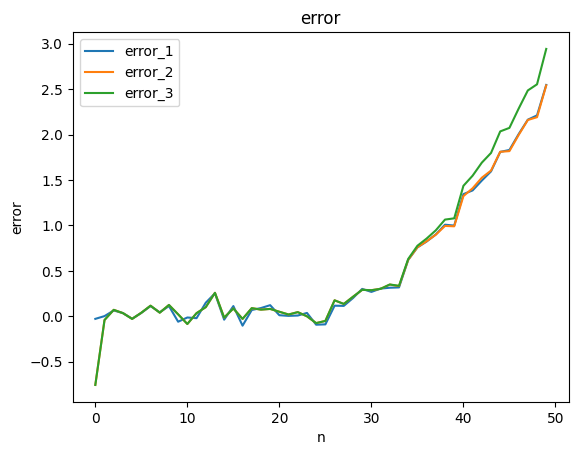

In [294]:
plt.plot(error_1.detach().cpu().numpy(),label='error_1')
plt.plot(error_2.detach().cpu().numpy(),label='error_2')
plt.plot(error_3.detach().cpu().numpy(),label='error_3')
plt.xlabel('n')
plt.ylabel('error')
plt.title('error')
plt.legend()
plt.show()

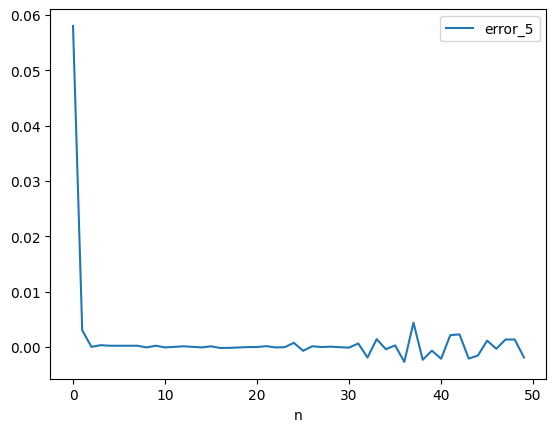

In [295]:
error_5=b_500_20000-d_600_25000
plt.plot(error_5.detach().cpu().numpy(),label='error_5')
plt.xlabel('n')
plt.legend()
plt.show()

In [296]:
# 0-100 20000
# tensor([-4.9993e+01, -1.2812e+01, -7.6439e+00, -7.1598e+00, -6.5095e+00,
#         -5.6153e+00, -4.6651e+00, -3.6987e+00, -3.2770e+00, -2.6482e+00,
#         -2.6477e+00, -1.8706e+00, -1.8622e+00, -1.6658e+00, -1.3334e+00,
#         -1.2025e+00, -9.7241e-01, -8.6871e-01, -8.5795e-01, -7.9155e-01,
#         -5.1720e-01, -5.0087e-01, -4.6173e-01, -4.4192e-01, -2.9187e-01,
#         -2.6489e-01, -2.0942e-01, -2.0048e-01, -1.9047e-01, -1.7534e-01,
#         -1.3054e-01, -1.2914e-01, -8.4303e-02, -8.3751e-02, -8.2882e-02,
#         -6.5835e-02, -4.3924e-02, -2.3980e-02, -1.2305e-02,  1.9596e-02,
#          3.3180e-02,  1.1026e-01,  1.4785e-01,  1.5626e-01,  1.8180e-01,
#          2.0197e-01,  2.4258e-01,  2.8590e-01,  3.0847e-01,  3.6319e-01],
#        device='cuda:1')

In [297]:
# 0-500 20000
# tensor([-4.9266e+01, -1.2769e+01, -7.6507e+00, -7.1596e+00, -6.5086e+00,
#         -5.6174e+00, -4.6689e+00, -3.6953e+00, -3.2893e+00, -2.7293e+00,
#         -2.5762e+00, -1.9258e+00, -1.8134e+00, -1.6713e+00, -1.3562e+00,
#         -1.1761e+00, -1.0467e+00, -8.8911e-01, -8.4066e-01, -7.5028e-01,
#         -5.5542e-01, -5.1589e-01, -4.9918e-01, -4.0479e-01, -3.0940e-01,
#         -3.0296e-01, -2.6865e-01, -2.2188e-01, -2.0477e-01, -1.6500e-01,
#         -1.4936e-01, -1.2617e-01, -1.2013e-01, -1.0128e-01, -9.3843e-02,
#         -8.4216e-02, -7.6711e-02, -6.9311e-02, -6.8499e-02, -6.0289e-02,
#         -5.8117e-02, -5.2000e-02, -4.9340e-02, -4.6622e-02, -4.3952e-02,
#         -4.0841e-02, -3.8040e-02, -3.5729e-02, -3.3490e-02, -3.3128e-02],
#        device='cuda:1')